In [39]:
import tensorflow as tf;
import tensorflow_datasets as tfds;
import matplotlib;
from matplotlib import pyplot as plt;
import seaborn as sns

# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [40]:
print( tf.__version__ )

2.17.0


In [41]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
train_data, val_data, test_data = tfds.load( "mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True )

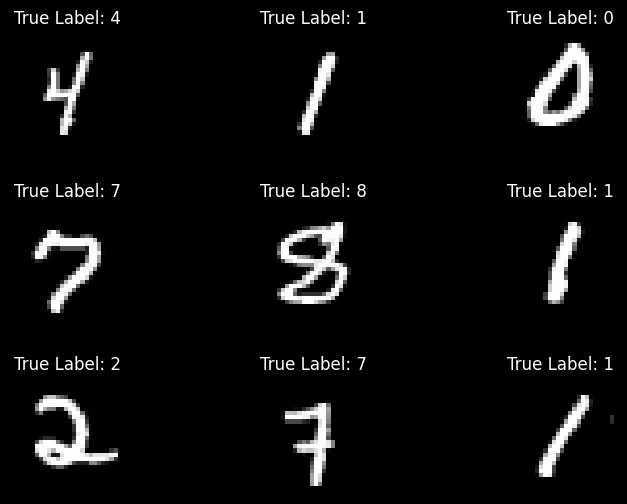

In [43]:
x_viz, y_viz = tfds.load( "mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True )[0]
x_viz = tf.squeeze( x_viz, axis=3 )

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)

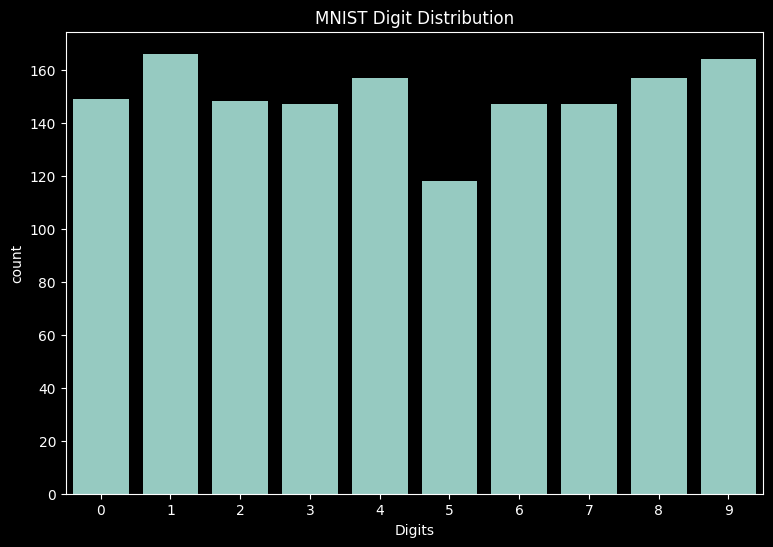

In [44]:
sns.countplot(x=y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

In [45]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

In [46]:
def xavier_init( shape ):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape;
  xavier_lim = tf.sqrt( 6. )/tf.sqrt( tf.cast( in_dim + out_dim, tf.float32 ) );
  weight_vals = tf.random.uniform( shape=( in_dim, out_dim ), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22 );
  return weight_vals;

In [47]:
class DenseLayer( tf.Module ):
    """
    """
    def __init__( self, out_dim, weight_init=xavier_init, activation=tf.identity ):
        """
        """
        self.out_dim = out_dim;
        self.weight_init = weight_init;
        self.activation = activation;
        self.built = False;

    def __call__( self, x ):
        """
        """
        if not self.built:
            self.in_dim = x.shape[1];
            self.W = tf.Variable( self.weight_init( shape = (self.in_dim, self.out_dim) ) );
            self.b = tf.Variable( tf.zeros( shape = (self.out_dim,) ) );
            self.built = True;

        intermediate = tf.add( tf.matmul ( x, self.W ), self.b );
        return self.activation( intermediate );


In [48]:
class MLP( tf.Module ):
    """
    """
    def __init__( self, layers ):
        """
        """
        self.layers = layers;

    @tf.function
    def __call__( self, x, preds=False ):
        """
        """
        for layer in self.layers:
            x = layer( x );
        return x;

In [49]:
def cross_entropy_loss( y_pred, y ):
    """
    """
    sparse_categorical_crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits( labels=y, logits=y_pred );
    return tf.reduce_mean( sparse_categorical_crossentropy );

In [50]:
def accuracy( y_pred, y ):
    """
    """
    class_preds = tf.argmax( tf.nn.sftmax( y_pred ), axis=1 );
    is_equal = tf.equal( y, class_preds );
    return tf.reduce_mean( tf.cast( is_equal, tf.float32 ) );

In [51]:
class GradientDesent( tf.Module ):
    """
    """
    def __init__( self, learning_rate ):
        """
        """
        self.learning_rate = learning_rate;
        self.title = f"Gradient Descent Optimizer: learning rate = {self.learning_rate}";

    def apply_gradients( self, grads, vars ):
        """
        """
        for grad, var in zip( grads, vars ):
            var.assign_sub( self.learning_rate * grad );

In [52]:
def train_step( x_batch, y_batch, lss, acc, model, optimizer ):
    """
    """
    with tf.GradientTape() as tape:
        y_pred = model( x_batch );
        loss = lss( y_pred, y_batch );
    grads = tape.gradient( loss, model.trainable_variables );
    optimizer.apply_gradients( grads, model.trainable_variables );
    return loss, acc( y_pred, y_batch );

def val_step( x_batch, y_batch, loss, acc, model ):
    """
    """
    y_pred = model( x_batch );
    batch_loss = loss( y_pred, y_batch );
    batch_acc = acc( y_pred, y_batch );
    return batch_loss, batch_acc;

In [53]:
def train_model( mlp, train_data, val_data, loss, acc, optimizer, epochs ):
    train_losses, train_accs = [], [];
    val_losses, val_accs = [], [];

    for epoch in range( epochs ):
        batch_losses_train, batch_accs = [], [];
        batch_losses_val, batch_accs_val = [], [];

        for x_batch, y_batch in train_data:
            batch_loss, batch_acc = train_step( x_batch, y_batch, loss, acc, mlp, optimizer );
            batch_losses_train.append( batch_loss );
            batch_accs.append( batch_acc );

        for x_batch, y_batch in val_data:
            batch_loss, batch_acc = val_step( x_batch, y_batch, loss, acc, mlp );
            batch_losses_val.append( batch_loss );
            batch_accs_val.append( batch_acc );

        # keep track of epoch level model performances
        train_loss, train_acc = tf.reduce_mean( batch_losses_train ), tf.reduce_mean( batch_accs );
        val_loss, val_acc = tf.reduce_mean( batch_losses_val ), tf.reduce_mean( batch_accs_val );
        train_losses.append( train_loss );
        train_accs.append( train_acc );
        val_losses.append( val_loss );
        val_accs.append( val_acc );
        print(f"Epoch: {epoch}" );
        print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}");
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}");
    return train_losses, train_accs, val_losses, val_accs;

In [57]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10
learning_rate = 0.01

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [58]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=GradientDesent(learning_rate), epochs=10)

TypeError: GradientDesent.__init__() missing 1 required positional argument: 'learning_rate'